<a href="https://colab.research.google.com/github/AmauryFaure/project_article_1/blob/master/Project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Article 1 :


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Importing pandas and numpy
import pandas as pd
import numpy as np

In [3]:
#Check python version
!python --version

Python 3.6.9


## Creating the training Dataset :

In [4]:
#Get tweets
df_to_moderate=pd.read_csv("/content/drive/MyDrive/article_1_data/selected_tweets.csv")
#Drop unused data
df_to_moderate=df_to_moderate.drop(["Id","source","Looked up word"],axis=1)
#Change column name
df_to_moderate["content"]=df_to_moderate["tweet (without @)"]
df_to_moderate=df_to_moderate.drop(["tweet (without @)"], axis=1)
#Drop empty lines
df_to_moderate=df_to_moderate.dropna()

In [5]:
#Get regular data
df_article1_messages=pd.read_excel("/content/drive/MyDrive/article_1_data/AmauryModerationAllMessagesInspireFrom3Aout2020.xlsx", sheet_name="ContenuNormal")
#Drop unused data
df_article1_messages=df_article1_messages.drop(["_id","sender","recipients.0","threadId","timestamp","EchantillonNormal"], axis=1)
#Assign label
df_article1_messages["Harmful"]=0

In [6]:
#Create training dataset. Balanced 50% for each class !
df_to_moderate=pd.concat([df_article1_messages[:200],df_to_moderate],ignore_index=True)

## Creating the test Datasets

Problem : we do not have a balanced Dataset of real examples from article 1 for which we know the real distribution.

What will we done instead :

- Test on the dataset of MLMA tweets. 
- See % that come back on Article 1 dataset. 

### Test MLMA Dataset

In [7]:
test=pd.read_csv("/content/drive/MyDrive/article_1_data/fr_dataset_test.csv")
#Dropping Unused columns
test=test.drop(test.columns[[7,8,9]],axis=1)
test=test.drop(columns=["HITId","directness","annotator_sentiment","target","group"])
#Changing sentiment to 0 (for normal) and 1 (for else) 
test["sentiment"]=[0 if test["sentiment"][x]=="normal" else 1 for x in range(test.shape[0])]

### Test A1 Dataset

In [8]:
df_a1_to_moderate=pd.read_excel("/content/drive/MyDrive/article_1_data/AmauryModerationAllMessagesInspireFrom3Aout2020.xlsx", sheet_name="ContenuToModerate")
df_a1_to_moderate=df_a1_to_moderate.drop(columns=["_id","sender","recipients.0","threadId","timestamp","EchantillonToModerate"])
# df_a1_to_moderate.columns=df_a1_to_moderate.columns.str.replace("\n"," ")
df_a1_to_moderate.head()

,content
0,"Non, la physique-chimie de lycée n’a pas grand..."
1,Merci infiniment d'avoir pris autant de temps ...
2,Bonjour ! Alors non la SVT et la biologie ce n...
3,salut\nJ'aimerais savoir ce qu'est exactement ...
4,je sais pas si j'ai répondu à toutes tes quest...


## Creating Fine-tuning Dataset:

In [9]:
# df_a1_fine_tune=pd.DataFrame(pd.concat([df_a1_to_moderate["content"],df_article1_messages["content"]]))
df_a1_fine_tune=pd.read_excel("/content/drive/MyDrive/article_1_data/AmauryModerationAllMessagesInspireFrom3Aout2020.xlsx", sheet_name="AllMessagesInspireFrom3Aout2020")
df_a1_fine_tune=df_a1_fine_tune.drop(columns=["_id","sender","recipients.0","threadId","timestamp","EchantillonToModerate","EchantillonNormal"])
df_a1_fine_tune.head()

,content
0,"Bonsoir, j’ai une formation dans l’aménagement..."
1,Tu peux me parler un peu de l’apprentissage de...
2,"Bonjour, \nTu veux te tourner vers quel parcou..."
3,Bonjour \nLa première année après bac peut fai...
4,"Bonsoir, je me présente je suis élève de Termi..."


## Implementing BoW and TF-IDF

In [10]:
#Creating arrays for test_values and labels
test_values=np.array(test["tweet"])
test_labels=np.array(test["sentiment"])
# Same but for training
train_values=np.array(df_to_moderate["content"])
#Extra step to Making sure everything is on a string format (some numbers might not be)
train_values=[str(train_values[i]) for i in range(len(train_values))]
train_labels=np.array(df_to_moderate["Harmful"])

In [11]:
from joblib import dump, load

#Import SGDClassifier (allows to implement logistic regression)
from sklearn.linear_model import SGDClassifier
#Import matplotlib for plots
%matplotlib inline
import matplotlib.pyplot as plt
#Import some metrics
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, roc_auc_score, confusion_matrix
#Import seaborn for plots
import seaborn as sns

#This function comes from : https://towardsdatascience.com/text-classification-with-extremely-small-datasets-333d322caee2
#It computes F1-score
def calc_f1(p_and_r):
    p, r = p_and_r
    return (2*p*r)/(p+r)

#This function comes from : https://towardsdatascience.com/text-classification-with-extremely-small-datasets-333d322caee2
#It computes some metrics
def compute_metrics(y_test, y_prob, verbose=False, return_metrics=True, confusion=False):
  precision, recall, threshold = precision_recall_curve(y_test, y_prob, pos_label = 1)

  #Optimizing the F1-score
  best_f1_index =np.argmax([calc_f1(p_r) for p_r in zip(precision, recall)])
  best_threshold, best_precision, best_recall = threshold[best_f1_index], precision[best_f1_index], recall[best_f1_index]

  y_test_pred = np.where(y_prob > best_threshold, 1, 0)
  
  f1 = f1_score(y_test, y_test_pred, pos_label = 1, average = 'binary')
  roc_auc = roc_auc_score(y_test, y_prob)
  acc = accuracy_score(y_test, y_test_pred)

  if confusion:
    cm = confusion_matrix(y_test, y_test_pred)
    print(cm)

    plt.title('Confusion Matrix')
    sns.set(font_scale=1.0) #for label size
    sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = ['Not harmful', 'Harmful'], yticklabels = ['Not harmful', 'Harmful'], annot_kws={"size": 14}, cmap = 'Blues')# font size

    plt.xlabel('Prediction')
    plt.ylabel('Truth')

  if verbose:
    print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | AUC: {:.3f} | Accuracy: {:.3f} \n'.format(f1, best_precision, best_recall, roc_auc, acc))
    
  if return_metrics:
    return np.array([f1, best_precision, best_recall, roc_auc, acc])

#Defining a function to do 10 times the logistic regression
def evaluate_log_reg(train_features, test_features, y_train, y_test):
    score=0
    metrics = np.zeros(5)
    for i in range(10):
        log_reg=SGDClassifier(loss="log", penalty='l2')
        log_reg.fit(train_features,y_train)
      
        y_prob=log_reg.predict_proba(test_features)[:,1]
        metrics+=compute_metrics(y_test,y_prob)
    metrics /=10

    return metrics


In [12]:
# Bag of Word
from sklearn.feature_extraction.text import CountVectorizer
#Declaring the vectorizer
bow=CountVectorizer()
#Fiting the model to the training dataset, and vectorizing the training dataset
train_bow=bow.fit_transform(train_values)
#Vectorizing test dataset
test_bow=bow.transform(test_values)
#Real metrics
metrics_bow=evaluate_log_reg(train_bow, test_bow, train_labels, test_labels)
#Metrics evaluated on train dataset (to see if overfitting)
metrics_train=evaluate_log_reg(train_bow, train_bow, train_labels, train_labels)
print(metrics_bow)
print(metrics_train)

[0.88635199 0.79692655 0.9987948  0.59982261 0.79634208]
[0.99749373 1.         1.         1.         0.9975    ]


In [13]:
# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer()
train_tfidf=tfidf.fit_transform(train_values)
test_tfidf=tfidf.transform(test_values)

metrics_tfidf=evaluate_log_reg(train_tfidf, test_tfidf, train_labels, test_labels)
metrics_train_tfidf=evaluate_log_reg(train_tfidf, train_tfidf, train_labels, train_labels)
print(metrics_tfidf)
print(metrics_train_tfidf)

[0.88656571 0.79764834 0.99816048 0.65224214 0.79689707]
[0.99749373 1.         1.         1.         0.9975    ]


### Implementing camembert : First Attempt :

In this attempt we are going to use transformers and PyTorch, using the latter for training.

In [15]:
!pip install transformers
!pip install sentencepiece

In [14]:
#Importing function to split training data into validation and train
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_values, train_labels, test_size=.2)

In [16]:
#Tokeinization for camembert
from transformers import CamembertTokenizer
tokenizer=CamembertTokenizer.from_pretrained("camembert-base")

In [17]:
#Tokenizing
train_encodings = tokenizer(train_texts, padding=True, truncation=True)
val_encodings = tokenizer(val_texts, padding=True,truncation=True)
test_encodings = tokenizer(test_values.tolist(), padding=True, truncation=True)

In [18]:
#Importing pyTorch
import torch

class A1Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # print(self.encodings.items())
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx],dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
#Utility to load dataset in batch
from torch.utils.data import DataLoader
#Importing camembdert and AdamW Optimizer
from transformers import CamembertForSequenceClassification, AdamW

#Model declaration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = CamembertForSequenceClassification.from_pretrained('camembert-base')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

#Training
for epoch in range(1):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels.long())
        loss = outputs[0]
        loss.backward()
        optim.step()

model.eval()

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

[[  32  779]
 [  21 3132]]
[0.88674972 0.80086912 0.99365683 0.68930516 0.79818365]


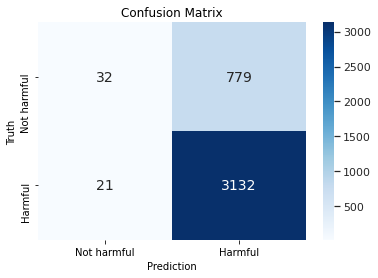

In [ ]:
#Evaluating the model : 
with torch.no_grad():
  input_ids = test_dataset[:]['input_ids'].to(device)
  attention_mask = test_dataset[:]['attention_mask'].to(device)
  labels = test_dataset[:]['labels'].to(device)
  outputs = model(input_ids, attention_mask=attention_mask)

  metrics_camembert=compute_metrics(labels.cpu().data.numpy(),outputs[0].cpu().data.numpy()[:,1], confusion=True)
  print(metrics_camembert)

In [ ]:
metrics_df=pd.DataFrame(metrics_bow.reshape((1,-1)), columns=["f1", "best_precision", "best_recall", "roc_auc", "acc"])
df2=pd.DataFrame(metrics_tfidf.reshape((1,-1)), columns=["f1", "best_precision", "best_recall", "roc_auc", "acc"])
df3=pd.DataFrame(metrics_camembert.reshape((1,-1)), columns=["f1", "best_precision", "best_recall", "roc_auc", "acc"])
metrics_df=metrics_df.append(df2,ignore_index=True)
metrics_df=metrics_df.append(df3,ignore_index=True)


In [ ]:
metrics_df.head()

,f1,best_precision,best_recall,roc_auc,acc
0,0.886337,0.796855,0.998858,0.598020,0.796292
1,0.886563,0.797442,0.998509,0.651417,0.796821
2,0.884426,0.795409,1.000000,0.548913,0.798184


On n'a pas de meilleure performance selon le modèle choisi. 
Etonnament le modèle camembert donne une aire sous la courbe ROC plus faible que les autres, alors que le reste des indicateurs sont similaires.


## Implementing Camembert : Second version :

Cette fois-ci on utilise toujours Transformers et PyTorch mais on utilise des fonctions plus haut niveau de Transformers. 

On va aussi tenter de fonctionner en deux étapes :
- "Language Modeling Fine-Tuning" : Adapter la représentation de la langue de CamemBERT au 47k messages d'Article 1
-Classifier (même méthode).

### Partie Language Modeling Fine-Tuning

In [31]:
# print(df_a1_fine_tune["content"].values.tolist())
fine_tune_values=df_a1_fine_tune["content"].values
fine_tune_values=[str(fine_tune_values[i]) for i in range(len(fine_tune_values))]

In [32]:
#Creating dataset for fine-tuning
fine_tuning_encodings=tokenizer(fine_tune_values,padding=True, truncation=True)

TypeError: ignored

In [33]:
fine_tuning_dataset=A1Dataset(fine_tuning_encodings,np.zeros((len(fine_tune_values))))

In [36]:
from transformers import CamembertModel, Trainer, TrainingArguments


fine_tune_training_args = TrainingArguments(
    output_dir='./results/fine',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs/fine',            # directory for storing logs
    logging_steps=10,
)

fine_tune_model=CamembertModel.from_pretrained("camembert-base")

fine_tune_trainer=Trainer(
    model=fine_tune_model,
    args=fine_tune_training_args,
    train_dataset=fine_tuning_dataset
)

In [37]:
fine_tune_trainer.train()

TypeError: ignored

### Partie classification

In [ ]:
#Crating dataset for Classification
train_dataset =  A1Dataset(train_encodings, train_labels)
val_dataset =  A1Dataset(val_encodings, val_labels)
test_dataset =  A1Dataset(test_encodings, test_labels)

In [ ]:
from transformers import CamembertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

model = CamembertForSequenceClassification.from_pretrained("camembert-base")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

Step,Training Loss
10,0.687700
20,0.691200
30,0.685900
40,0.682100
50,0.672100
60,0.663100


TrainOutput(global_step=60, training_loss=0.6803353706995646, metrics={'train_runtime': 42.0907, 'train_samples_per_second': 1.425, 'total_flos': 170130077740800, 'epoch': 3.0})

In [ ]:
predictions =trainer.predict(test_dataset)

In [ ]:
print(predictions[1])

[1 1 1 ... 1 0 1]


In [ ]:
accuracy=accuracy_score(test_dataset.labels,predictions[1])
f1=f1_score(test_dataset.labels,predictions[1])
print(accuracy)
print(f1)
print(test_dataset.labels)
print(predictions[1])

1.0
1.0
[1 1 1 ... 1 0 1]
[1 1 1 ... 1 0 1]


In [ ]:
model.save_pretrained("/content/drive/MyDrive/article_1_model/camembert")

Ce modèle semble meilleur sur le dataset MLMA (précision à 1, F1-score à 1, classifieur parfait). Possibilité d'overfit ? (cela semble confirmé par le 0 message qui ressort en fin de notebook).

## Analyse : Quelles implications sur les messages à modérer A1 ? 

### Test avec BoW+ Log Reg


In [ ]:
test_values=np.array(test["tweet"])
test_labels=np.array(test["sentiment"])

train_values=np.array(df_to_moderate["content"])
train_values=[str(train_values[i]) for i in range(len(train_values))]
train_labels=np.array(df_to_moderate["Harmful"])

In [ ]:

bow=CountVectorizer()
train_bow=bow.fit_transform(train_values)
test_bow=bow.transform(test_values)

# metrics_bow=evaluate_log_reg(train_bow, test_bow, train_labels, test_labels)

log_reg=SGDClassifier(loss="log", penalty='l2')
log_reg.fit(train_bow,train_labels)

prediction=log_reg.predict(bow.transform(df_a1_to_moderate["content"]))

In [ ]:
print(prediction)
print(f"Le modèle fait ressortir {sum(prediction)} messages problématiques")
print(f"Nombre de messages problématiques originaux : {df_a1_to_moderate.shape[0]}")

[0. 0. 0. ... 0. 0. 0.]
Le modèle fait ressortir 944.0 messages problématiques
Nombre de messages problématiques originaux : 8233


In [ ]:
indexes=[ i for i in range(len(prediction)) if prediction[i]==1]
df_a1_bow_moderate=df_a1_to_moderate.iloc[indexes]
print(indexes)

for i in range(10): 
  print(df_a1_bow_moderate.iloc[i]["content"])

[16, 36, 45, 52, 77, 80, 82, 88, 90, 141, 143, 145, 164, 165, 172, 190, 194, 204, 210, 220, 233, 236, 243, 247, 252, 255, 266, 275, 281, 282, 298, 299, 308, 316, 327, 331, 333, 335, 337, 338, 340, 343, 353, 365, 375, 387, 388, 431, 437, 442, 450, 453, 464, 471, 480, 491, 493, 499, 504, 505, 521, 526, 527, 528, 550, 558, 562, 566, 570, 571, 572, 577, 591, 595, 641, 642, 646, 649, 654, 656, 693, 694, 697, 698, 699, 700, 701, 729, 749, 757, 763, 770, 776, 779, 799, 803, 809, 829, 837, 838, 865, 904, 912, 913, 916, 918, 957, 958, 963, 976, 983, 987, 1040, 1041, 1043, 1046, 1054, 1056, 1071, 1081, 1083, 1094, 1097, 1108, 1109, 1116, 1124, 1126, 1129, 1130, 1138, 1139, 1144, 1151, 1170, 1186, 1192, 1220, 1247, 1262, 1270, 1271, 1281, 1291, 1300, 1305, 1308, 1313, 1319, 1329, 1377, 1386, 1388, 1393, 1410, 1421, 1426, 1430, 1447, 1452, 1458, 1460, 1472, 1480, 1482, 1493, 1534, 1541, 1542, 1550, 1561, 1564, 1569, 1579, 1602, 1607, 1609, 1612, 1618, 1622, 1636, 1688, 1696, 1698, 1699, 1702, 1705

C'est peut satisfaisant, on remarque trop messages qui sont totalement normaux et pour lesquels on ne peut pas trouver de raison de modération. 

Il faudrait ré-entrainer avec des données plus précises d'Article 1. L'approche ne semble a priori pas très prometteuse (même si son coût étant très limité peut valoir l'approche). 

### Test avec Camembert v1 :


In [ ]:
a1_test = tokenizer(np.array(df_a1_to_moderate["content"]).tolist(), padding=True, truncation=True)
a1_test_dataset=A1Dataset(a1_test,np.zeros(df_a1_to_moderate.shape[0]))

In [ ]:
# print(a1_test["input_ids"])
# # predictions=

model.load_state_dict(torch.load("/content/drive/MyDrive/article_1_data/camembert.pt"))
predictions=[]

test_loader=DataLoader(a1_test_dataset, batch_size=16, shuffle=False)
with torch.no_grad():
  for batch in test_loader:

    inputs_test=batch["input_ids"].to(device)
    attention_mask_test=batch["attention_mask"].to(device)
    # print(model(inputs_test,attention_mask=attention_mask_test))
    outputs=model(inputs_test,attention_mask=attention_mask_test)
    predictions.append(np.argmax(outputs[0].cpu().data.numpy(), axis=1).tolist())


In [ ]:
predictions=[item for sublist in predictions for item in sublist]
print(predictions)

print(f"Le modèle fait ressortir {sum(predictions)} messages problématiques")
print(f"Sur {len(predictions)} messages")

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
indexes_camembert=[ i for i in range(len(predictions)) if predictions[i]==1]
df_a1_bow_moderate=df_a1_to_moderate.iloc[indexes_camembert]
print(indexes_camembert)

for i in range(51): 
  print(df_a1_bow_moderate.iloc[i]["content"])

[36, 77, 210, 316, 521, 534, 1124, 1273, 1538, 1849, 2008, 2169, 2267, 2286, 2287, 2291, 2313, 2347, 2498, 2499, 2763, 2911, 3194, 3497, 4001, 4199, 4200, 4201, 4204, 4206, 4208, 4211, 4213, 4214, 4217, 4220, 4227, 4701, 4783, 5459, 5628, 6095, 6112, 6149, 6504, 6507, 6512, 7092, 7199, 7805, 7853]
t'es un amour merciiiiiiiiii
*inébranlable est un caprice de mon correcteur automatique
Hello Léane* !! correcteur farceur :)
woaw t’es grave deter mdrr
https://drive.google.com/file/d/1lkHW998wL4xGX-ptekBuJ09iroz_PMdz/view?usp=drivesdk
Merci, tes réponses sont très complètes ! TooGoodToGo va devenir mon meilleur ami ahah
La communication aha
Après paris j’y penses paaas vrmnt pck j’veux pas partir non plus loin de chez moi, je suis vers cannes 06
Quel hasard que tu soit à pissarro !
D’accord merveaucoup pour l’aide
Insta : nonoo__o 
:)
Derien, il y a pas de quoi
Mais oui sinon c’est abusé je suis d’accord mdrr
Ok vas-y
et oui vas-y passes sur insta
Ah ouais ! En fait c’est compliqué ct’histo

Beaucoup moins de messages ressortent, et surtout les messages semblent plus cohérent (présence de snapchat, insta, facebook ou encore smiley). On note cependant que cela reste des messages relativement "innocents".

### Test avec Camembert v2:

Test préliminaire sans l'étape de language modeling adaptation

In [ ]:
predictions_a1=trainer.predict(a1_test_dataset)

In [ ]:
print(sum(predictions_a1[1]))
print(predictions_a1[1])  
# print(pred)

0
[0 0 0 ... 0 0 0]


On remarque ici que ce nouvel algorithme ne détecte aucun cas de messages à modérer. C'est potentiellement car les messages d'entrainement sont trop violent ? 